In [1]:
# инициализация видеокарты в TF2

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train = np.loadtxt('data/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('data/test.csv', delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
# добавляем размерность канала
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

## Визуализируем исходные данные

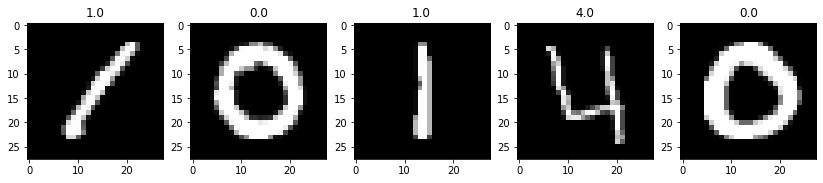

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [7]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.2, random_state=42)

## Собираем сверточную сеть для обучения

In [8]:
glorot = keras.initializers.glorot_normal(seed=123455) # генерирует веса из усеченного нормального распределения с центром 0 и stddev = sqrt(2 / (fan_in + fan_out))

In [9]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(6, 
                              kernel_size=(5, 5), 
                              padding='same', 
                              activation='relu', 
                              input_shape=x_train.shape[1:],
                              bias_initializer=glorot,
                              kernel_initializer=glorot))

model.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))


model.add(keras.layers.Conv2D(16, 
                              kernel_size=(5, 5),
                              padding='valid',
                              activation='relu', 
                              bias_initializer=glorot,
                              kernel_initializer=glorot))

model.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(10, activation='softmax',
                             bias_initializer=glorot,
                             kernel_initializer=glorot))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                4010      
Total params: 6,582
Trainable params: 6,582
Non-trainable params: 0
______________________________________________________

## One hot encoding разметки

In [11]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

## Запускаем обучение

In [12]:
model.fit(x_train, y_train_labels,
          batch_size=32, 
          epochs=10,
          validation_split=0.2)

Epoch 1/10
840/840 [==============================] - 6s 4ms/step - loss: 5.6100 - accuracy: 0.6670 - val_loss: 0.2727 - val_accuracy: 0.9299
Epoch 2/10
840/840 [==============================] - 3s 4ms/step - loss: 0.2126 - accuracy: 0.9405 - val_loss: 0.1831 - val_accuracy: 0.9530
Epoch 3/10
840/840 [==============================] - 3s 4ms/step - loss: 0.1226 - accuracy: 0.9628 - val_loss: 0.1265 - val_accuracy: 0.9655
Epoch 4/10
840/840 [==============================] - 3s 4ms/step - loss: 0.0928 - accuracy: 0.9715 - val_loss: 0.1118 - val_accuracy: 0.9665
Epoch 5/10
840/840 [==============================] - 3s 4ms/step - loss: 0.0723 - accuracy: 0.9768 - val_loss: 0.1371 - val_accuracy: 0.9628
Epoch 6/10
840/840 [==============================] - 3s 4ms/step - loss: 0.0698 - accuracy: 0.9774 - val_loss: 0.1146 - val_accuracy: 0.9702
Epoch 7/10
840/840 [==============================] - 3s 4ms/step - loss: 0.0574 - accuracy: 0.9814 - val_loss: 0.1070 - val_accuracy: 0.9707
Epoch 

## Предсказываем класс объекта

In [13]:
pred_val = model.predict_classes(x_val)

## Оцениваем качество решение на валидационной выборке

In [14]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9767857142857143


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       816
         1.0       0.99      0.99      0.99       909
         2.0       0.98      0.99      0.99       846
         3.0       0.97      0.99      0.98       937
         4.0       0.97      0.99      0.98       839
         5.0       0.99      0.93      0.96       702
         6.0       0.97      0.99      0.98       785
         7.0       0.99      0.98      0.98       893
         8.0       0.94      0.98      0.96       835
         9.0       0.99      0.94      0.96       838

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



In [16]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[803   0   1   1   0   0   5   0   5   1]
 [  0 901   1   1   1   0   1   2   2   0]
 [  0   2 838   1   1   0   0   0   3   1]
 [  1   0   4 926   0   2   0   1   3   0]
 [  1   1   0   0 827   0   4   0   2   4]
 [  1   1   0  18   1 650  12   0  17   2]
 [  1   1   0   0   0   0 779   0   4   0]
 [  1   3   3   3   3   0   0 875   3   2]
 [  1   2   7   3   0   0   0   1 820   1]
 [  0   3   1   2  20   5   0   9  12 786]]


## Предсказания на тестовых данных

In [17]:
pred_test = model.predict_classes(test_img)

## Визуализируем предсказания

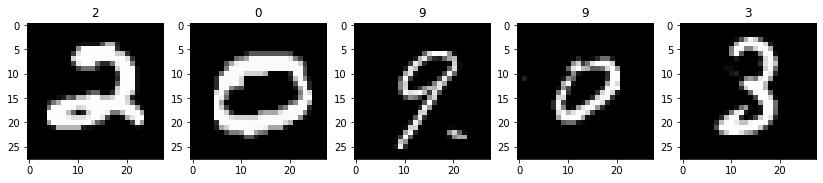

In [18]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);